In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,log_loss

import sys
sys.path.insert(0,"libs")
import data_cleaning as dc

### Split Given Training Data into Training and Test Sets

In [3]:
train = pd.read_csv("data/train.csv")

train = dc.massage_df(train)

In [4]:
def age_type(age_in_days):
    age_category_in_days = [32,185,365,3650] # < 1 month, < 6 months, < 1 year, < 10 years
    young = 32
    old   = 1000
    if age_in_days < young:
        return "young"
    elif age_in_days < old:
        return "middle"
    else:
        return "old"
    # end if
# end def age_type
train["age_type"] = train.age_numeric_days.apply(age_type)

In [5]:
# split all available data into test and train subsets
frac = .6 # use 60% data for training
test_rows = np.random.choice(train.index.values
            ,int(round( len(train)*frac )),replace=False )
mytrain = train.ix[test_rows]
mytest  = train.drop(test_rows)

### Choose Features and Perform Linear Regression (Logit)

In [9]:
# prepare training data

# here is a list of all useful features we created (from train.columns)
#features = ["neuter_status","AnimalType",'day_of_week', 'day_of_month', 'day_of_year', 'season',
#       'month', 'has_Lilac', 'has_Tortie', 'has_Blue', 'has_Gray', 'has_Brown',
#       'has_Point', 'has_Black', 'has_White', 'has_Tabby', 'has_Agouti',
#       'has_Orange', 'has_Calico', 'has_Lynx', 'has_Tan', 'age_type']

features = ["AnimalType","neuter_status"]

mytrain_features = pd.get_dummies(mytrain[features])
mytrain_outcomes = mytrain.OutcomeType
mytest_features = pd.get_dummies(mytest[features])
mytest_outcomes = mytest.OutcomeType

# train
classifier = LogisticRegression()
classifier.fit(mytrain_features,mytrain_outcomes);

### Measure Success/Failure

50 percentile on Kaggle has log-loss = 0.84434

In [10]:
predictions = classifier.predict(mytest_features)
prediction_probabilities = classifier.predict_proba(mytest_features)

# check performance
acc = accuracy_score(mytest_outcomes, predictions)
los = log_loss( pd.get_dummies( mytest.OutcomeType ).values, prediction_probabilities)
print("accuracy = {0:1.2f} \nlog-loss = {1:1.3f}".format(acc,los) )

accuracy = 0.61 
log-loss = 0.988


### Specular the Reason of Success/Failure

In [11]:
mytrain_outcomes.value_counts()

Adoption           6421
Transfer           5643
Return_to_owner    2908
Euthanasia          950
Died                115
Name: OutcomeType, dtype: int64

In [12]:
pd.Series(predictions).value_counts()

Adoption    7434
Transfer    3258
dtype: int64

In [13]:
mytest_outcomes.value_counts()

Adoption           4348
Transfer           3779
Return_to_owner    1878
Euthanasia          605
Died                 82
Name: OutcomeType, dtype: int64

logistic regression only captures the most dominant input/output correlation?

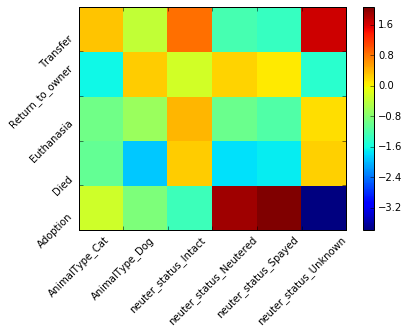

In [14]:
fig = plt.figure()
ax  = fig.add_subplot(111)

pcm = ax.pcolormesh(classifier.coef_)
xrange = ax.get_xticks()
yrange = ax.get_yticks()

ax.set_yticklabels(classifier.classes_,rotation=45)
ax.set_xticklabels(mytrain_features.columns,rotation=45)

fig.colorbar(pcm)